In [16]:
# set env via .env file
import os
import sys
import pathlib 
import numpy as np
import pandas as pd
import tensorflow as tf
from importlib import reload
import pandas_datareader.data as web
import requests_cache
import datetime
import munch

import math
from cachetools import TTLCache
import time
import ray
import psutil
from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import mpl_finance as mf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shared
import config
import provider_yfinance as provider
import plot

reload(shared)
reload(config)
reload(provider)
reload(plot)

plot.Notebook()

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

cfg = config.get_config('^GDAXI', False)
config.save_config(cfg)

config> read from config file: 'Munch({'base': Munch({'cache_dir': '/mnt/c/notebooks/sandbox/cache', 'cache_enabled': False, 'config_file_path': '/mnt/c/notebooks/sandbox/config.json', 'current_dir': '/mnt/c/notebooks/sandbox'}), 'datasets': Munch({'raw': Munch({'benchmarks': ['000001.SS', 'AUDUSD=X', 'B0=F', 'BO=F', 'BTCUSD=X', 'BZ=F', 'C=F', 'CC=F', 'CL=F', 'CNY=X', 'CT=F', 'ETHUSD=X', 'EURCAD=X', 'EURCHF=X', 'EURGBP=X', 'EURHUF=X', 'EURJPY=X', 'EURJPY=X', 'EURSEK=X', 'EURUSD=X', 'FC=F', 'GBPJPY=X', 'GBPUSD=X', 'GC=F', 'HG=F', 'HKD=X', 'HO=F', 'IDR=X', 'IMOEX.ME', 'INR=X', 'JPY=X', 'KC=F', 'KW=F', 'LB=F', 'LC=F', 'LH=F', 'MXN=X', 'MYR=X', 'NG=F', 'NZDUSD=X', 'O=F', 'OJ=F', 'PA=F', 'PHP=X', 'PL=F', 'RB=F', 'RR=F', 'RUB=X', 'S=F', 'SB=F', 'SGD=X', 'SI=F', 'SM=F', 'THB=X', 'ZAR=X', 'ZG=F', 'ZI=F', '^AORD', '^AXJO', '^BFX', '^BSESN', '^BUK100P', '^BVSP', '^CASE30', '^DJI', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^GSPTSE', '^HSI', '^IPSA', '^IXIC', '^JKSE', '^JN0U.JO', '^KLSE', '^KS11', '^M

In [10]:
%%time

cfg_stocks, data_stocks = provider.load_stocks(cfg)

tickers-stocks> downloading histories ...
[*********************100%***********************]  30 of 30 completed
WARN: tickers-stocks> #missing: 24175
ticker-1COV.DE> loading ticker data ...
ticker-ADS.DE> loading ticker data ...
ticker-ALV.DE> loading ticker data ...
ticker-BAS.DE> loading ticker data ...
ticker-BAYN.DE> loading ticker data ...
ticker-BEI.DE> loading ticker data ...
WARN: ticker-BEI.DE> #missing: 10
ticker-BMW.DE> loading ticker data ...
ticker-CON.DE> loading ticker data ...
yf-cashflowStatementHistory> internal error: Internal Server Error
yf-cashflowStatementHistoryQuarterly> internal error: Internal Server Error
yf-balanceSheetHistory> internal error: Internal Server Error
yf-balanceSheetHistoryQuarterly> internal error: Internal Server Error
yf-incomeStatementHistory> internal error: Internal Server Error
yf-incomeStatementHistoryQuarterly> internal error: Internal Server Error
yf-earnings> internal error: Internal Server Error
ticker-DAI.DE> loading ticker data 

In [11]:
%%time

cfg_benchmarks, data_benchmarks = provider.load_benchmarks(cfg)

tickers-benchmarks> downloading histories ...
[*********************100%***********************]  89 of 89 completed
WARN: tickers-benchmarks> #missing: 425366
ticker-000001.SS> loading ticker data ...
ticker-AUDUSD=X> loading ticker data ...
ticker-B0=F> loading ticker data ...
- B0=F: 1d data not available for startTime=-2208988800 and endTime=1576540779. Only 100 years worth of day granularity data are allowed to be fetched per request.
ticker-BO=F> loading ticker data ...
ticker-BTCUSD=X> loading ticker data ...
ticker-BZ=F> loading ticker data ...
ticker-C=F> loading ticker data ...
- C=F: 1d data not available for startTime=-2208988800 and endTime=1576540913. Only 100 years worth of day granularity data are allowed to be fetched per request.
ticker-CC=F> loading ticker data ...
ticker-CL=F> loading ticker data ...
ticker-CNY=X> loading ticker data ...
ticker-CT=F> loading ticker data ...
ticker-ETHUSD=X> loading ticker data ...
ticker-EURCAD=X> loading ticker data ...
ticker-EURC

In [17]:
dates = next(shared.filter_dates_generator(cfg, -1))
dates

Munch({'train_start_dt': datetime.datetime(2019, 9, 24, 0, 0), 'train_end_dt': datetime.datetime(2019, 11, 5, 0, 0), 'predict_start_dt': datetime.datetime(2019, 11, 6, 0, 0), 'predict_end_dt': datetime.datetime(2019, 11, 12, 0, 0)})

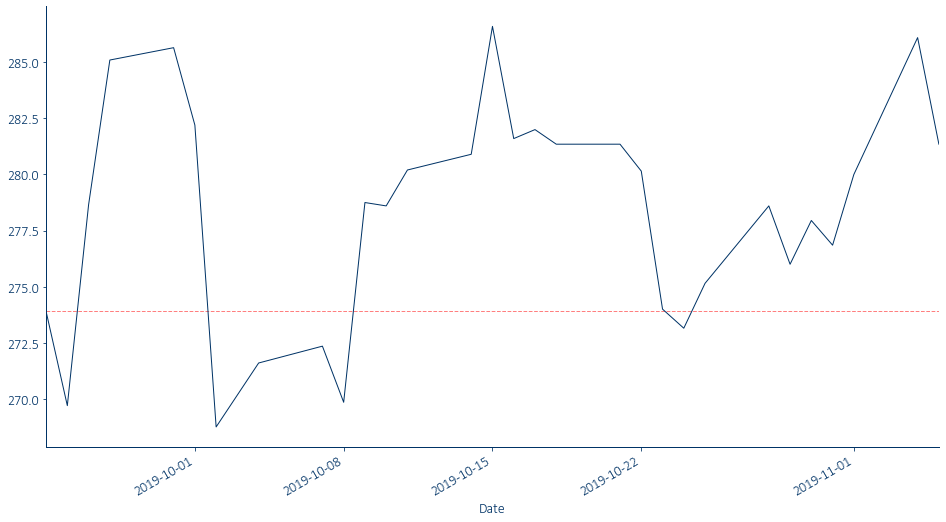

In [18]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates)
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

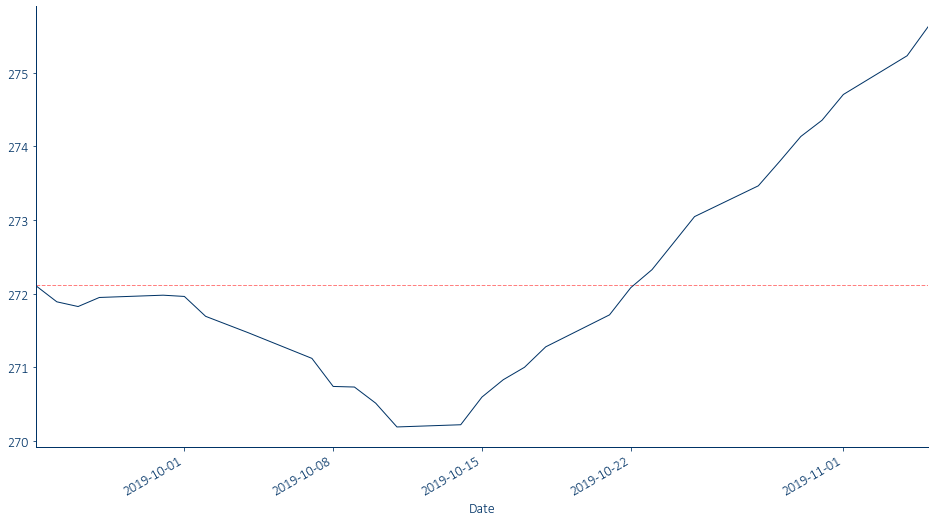

In [20]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_ma(cfg.train.window_trading_days[-1]))
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

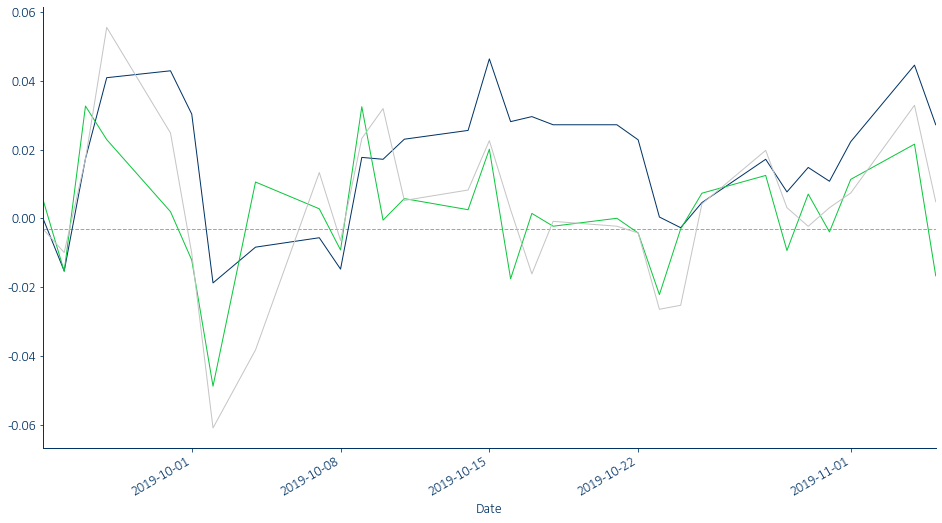

In [21]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_rel) - 1
s.plot()
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_loglag(cfg.train.lag_trading_days[0]))
s.plot()
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_loglag(cfg.train.lag_trading_days[1]))
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

In [36]:
data_stocks.tickers['ADS.DE'].calendar.index.rename('date', inplace=True)

In [66]:
data_benchmarks.tickers['BTCUSD=X'].history

,open,high,low,close,volume,dividends,stock_splits
Date,,,,,,,
2010-07-19,0.0858,0.0772,0.0931,0.0808,4900,0,0
2010-07-20,0.0808,0.0743,0.0818,0.0747,2000,0,0
2010-07-21,0.0747,0.0663,0.0792,0.0792,4200,0,0
2010-07-22,0.0792,0.0505,0.0818,0.0505,12900,0,0
2010-07-23,0.0505,0.0505,0.0677,0.0626,14100,0,0
...,...,...,...,...,...,...,...
2019-12-11,7277.1997,7195.5283,7324.1562,7217.4287,0,0,0
2019-12-12,7216.7412,7164.7407,7266.6387,7243.1328,0,0,0
2019-12-13,7244.6602,7227.1201,7293.5630,7269.6821,0,0,0
